In [208]:
# prelude
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# -----------------------------------------------------------------------------
from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618         # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 0

# getaround project

* https://app.jedha.co/course/project-deployment-ft/getaround-analysis-ft

# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* ~~create figures with powerpoint to illustrate~~
* replace ``delay_at_checkout_in_minutes`` with slices of 5, 15, 30 and 60... minutes of delay 
    * the idea is to simplify the analysis 
    * then remove ``delay_at_checkout_in_minutes`` ? 
    * use the length of the slice as an hyperparameter and see how it helps to fight overfit ?

# Specifications (summary)

|field name	                                  |  Comment        |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
|rental_id	                                  |  Unique identifier of the rental|
|car_id	                                      |  Unique identifier of the car |
|checkin_type	                              |  Flow used for both checkin and checkout. (ie. access and return the car) <br> mobile = rental agreement signed on the owner's smartphone <br> connect = car equiped with the Connect technology , opened by the driver with his smartphone <br> Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case |
|state	                                      |  canceled means that the rental did not happen (was canceled by the driver or the owner).
|delay_at_checkout_in_minutes	              |  Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
|previous_ended_rental_id	                  |  id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
|time_delta_with_previous_rental_in_minutes	  |  Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


Questions from the product manager : 

* How often are drivers late for the next check-in? How does it impact the next driver?
* How many rentals would be affected by the feature depending on the threshold and scope we choose?
* How many problematic cases will it solve depending on the chosen threshold and scope?
* Which share of our owner’s revenue would potentially be affected by the feature?

# EDA (Delay Analysis)

In [209]:
# -----------------------------------------------------------------------------


def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # TODO try this : df = df[~((df['price'] < (Q1–1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
# Remove outliers using z-score
# TODO try this
# from scipy import stats
# df = df[(np.abs(stats.zscore(df[['price']])) < 3)]

def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    
    return df

# print(df.shape)
# for col in col_outliers:
#     df = remove_Outliers(df, col, method="sigma")
# print(df.shape)

In [210]:
# df = pd.read_excel('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')
df = pd.read_excel(k_Current_dir/k_AssetsDir/"get_around_delay_analysis.xlsx", sheet_name="rentals_data")

print(f"\n\nPreview of the dataset :")
display(df.sample(20))



Preview of the dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,Unnamed: 7
12748,574113,324940,mobile,ended,-47.0,NaN,NaN,NaN
1920,550070,273133,mobile,ended,163.0,NaN,NaN,NaN
19549,541161,396009,connect,canceled,NaN,NaN,NaN,NaN
11854,557461,194343,connect,ended,-29.0,505628.0,90.0,NaN
17523,538285,408025,mobile,canceled,NaN,NaN,NaN,NaN
1714,556617,317237,mobile,ended,185.0,NaN,NaN,NaN
9009,551957,359045,connect,ended,3.0,546597.0,30.0,NaN
20010,566951,414939,mobile,canceled,NaN,NaN,NaN,NaN
9755,568183,245379,mobile,ended,-2.0,NaN,NaN,NaN
511,521364,257207,mobile,ended,694.0,NaN,NaN,NaN


In [211]:
print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))




% of missing values :


rental_id                                      0.00
car_id                                         0.00
checkin_type                                   0.00
state                                          0.00
delay_at_checkout_in_minutes                  23.29
previous_ended_rental_id                      91.36
time_delta_with_previous_rental_in_minutes    91.36
Unnamed: 7                                    99.66
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* 90% of the rentals happen more than 12 hours before the current one
* The last column can be dropped 


In [212]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    # drop
    df.drop(columns="Unnamed: 7", inplace=True)
    df.drop_duplicates(inplace=True)

    # format 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")
    
    # cast 
    df['rental_id'] = df['rental_id'].astype(str)
    df['car_id'] = df['car_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].astype(str)
    df['previous_ended_rental_id'] = df['previous_ended_rental_id'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)


    # other preprocessing should come here
    # df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len

    return df

In [213]:
df = preprocessor(df)
print(f"\n\nPreview of the preprocessed dataset :")
# display(df.head())
display(df.sample(20))



Preview of the preprocessed dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
16280,547460,411419,mobile,ended,-1272.0,NaN,NaN
17206,538959,377926,mobile,canceled,NaN,NaN,NaN
9932,552205,397786,mobile,ended,-4.0,NaN,NaN
8796,564319,378749,mobile,ended,5.0,NaN,NaN
19630,555422,190291,connect,canceled,NaN,NaN,NaN
18401,534659,284250,mobile,canceled,NaN,NaN,NaN
8164,538593,377591,connect,ended,9.0,NaN,NaN
4696,557344,381994,mobile,ended,53.0,554398,60.0
12243,553209,412439,mobile,ended,-36.0,NaN,NaN
8958,539094,403239,mobile,ended,4.0,NaN,NaN


In [214]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "mean" : Mean value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col  = df[col_name].max()
            min_of_col  = df[col_name].min()
            mean_of_col = df[col_name].mean()
            outlier_hi  = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo  = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            mean_of_col = np.nan
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "mean"                : round(mean_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [215]:
print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   





The dataset consists of :
	        2 dimensions
	   21_310 observations
	        7 features    


% of data type :


,types,as_%
object,5,71.43
float64,2,28.57




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
5,previous_ended_rental_id,object,19469,91.36,1841,1788,1.00,1.0,NaN,-1.0,-1.00,"{'537243': 4, '547969': 3, '541079': 3, '54657..."
6,time_delta_with_previous_rental_in_minutes,float64,19469,91.36,1841,25,-484.50,0.0,279.29,720.0,1043.07,"{0.0: 279, 60.0: 183, 120.0: 137, 720.0: 130, ..."
4,delay_at_checkout_in_minutes,float64,4964,23.29,16346,1745,-2947.98,-22433.0,59.70,71084.0,3067.39,"{4.0: 165, 6.0: 152, 2.0: 151, 7.0: 150, 9.0: ..."
0,rental_id,object,0,0.00,21310,21310,1.00,1.0,NaN,-1.0,-1.00,"{'532240': 1, '522106': 1, '568794': 1, '53869..."
1,car_id,object,0,0.00,21310,8143,1.00,1.0,NaN,-1.0,-1.00,"{'334190': 33, '241021': 29, '392479': 29, '34..."
2,checkin_type,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'mobile': 17003, 'connect': 4307}"
3,state,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'ended': 18045, 'canceled': 3265}"


### <span style="color:orange"><b>Comments :</b></span>
* Only 2 values for ``checkin_type`` (mobile, connect) and ``state`` (ended, canceled) 
* There are "only" 25 uniques value in `time_delta_with_previous_rental_in_minutes` 
* Many outliers in ``delay_at_checkout_in_minutes``

## About checkin_type

Nb mobile  :  17_003
Nb connect :   4_307


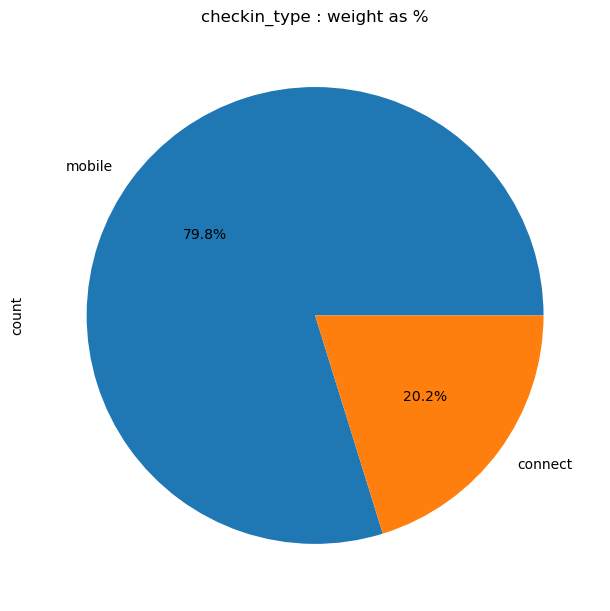

In [216]:
counts = df["checkin_type"].value_counts()
print(f"Nb mobile  : {counts['mobile']:>7_}")
print(f"Nb connect : {counts['connect']:>7_}")

_ = counts.plot.pie(title="checkin_type : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* 20% of the checkin/checkout are made via connected cars  


## About state 

Nb ended    :  18_045
Nb canceled :   3_265


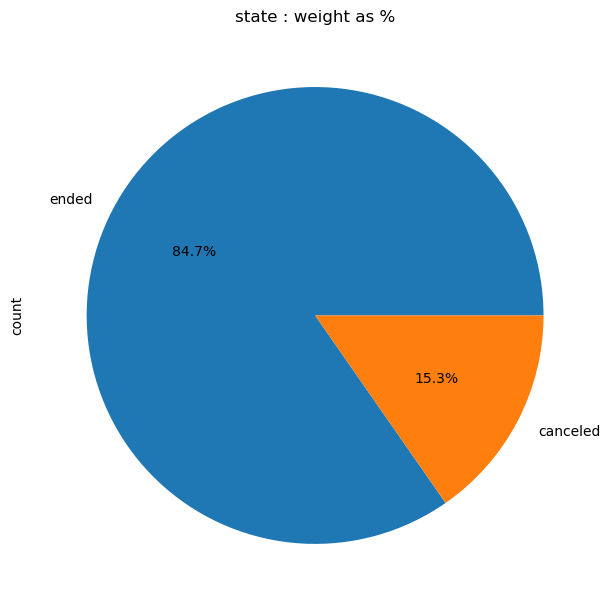

In [217]:
counts = df["state"].value_counts()
print(f"Nb ended    : {counts['ended']:>7_}")
print(f"Nb canceled : {counts['canceled']:>7_}")

_ = counts.plot.pie(title="state : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

In [218]:
display(df[df["state"]=="canceled"].sample(10))

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
17792,551113,289199,connect,canceled,NaN,NaN,NaN
16901,537759,400371,mobile,canceled,NaN,NaN,NaN
21303,569325,345079,mobile,canceled,NaN,NaN,NaN
19025,544284,178845,mobile,canceled,NaN,NaN,NaN
20620,575391,243474,mobile,canceled,NaN,NaN,NaN
17824,557161,321273,mobile,canceled,NaN,NaN,NaN
18546,528932,284482,mobile,canceled,NaN,NaN,NaN
18819,537762,289383,mobile,canceled,NaN,NaN,NaN
17086,548104,375915,mobile,canceled,NaN,NaN,NaN
20098,550840,308038,connect,canceled,NaN,NaN,NaN


### <span style="color:orange"><b>Comments :</b></span>
* 15% of the rentals are canceled
* Obviously, in these cases, there is no delay_at_checkout_in_minutes  


## About time_delta_with_previous_rental_in_minutes

In [219]:
print("Unique values in time_delta_with_previous_rental_in_minutes : ")
display(sorted(df["time_delta_with_previous_rental_in_minutes"].unique()))

Unique values in time_delta_with_previous_rental_in_minutes : 


[nan,
 0.0,
 30.0,
 60.0,
 90.0,
 120.0,
 150.0,
 180.0,
 210.0,
 240.0,
 270.0,
 300.0,
 330.0,
 360.0,
 390.0,
 420.0,
 450.0,
 480.0,
 510.0,
 540.0,
 570.0,
 600.0,
 630.0,
 660.0,
 690.0,
 720.0]

Text(0.5, 0, 'Minutes')

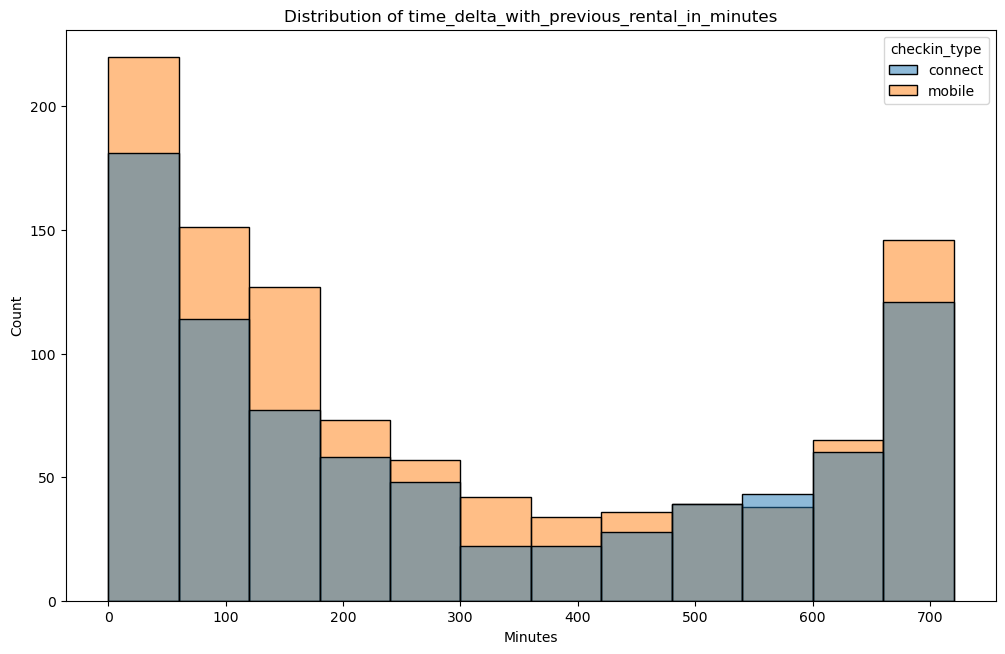

In [220]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="time_delta_with_previous_rental_in_minutes", hue="checkin_type", hue_order = ["connect", "mobile"]) #, bins=100, , kde=True

ax.set_title("Distribution of time_delta_with_previous_rental_in_minutes")
ax.set_xlabel("Minutes")
# # ax.set_xlim(-2000, 2000)
# plt.show()

## About delay_at_checkout_in_minutes

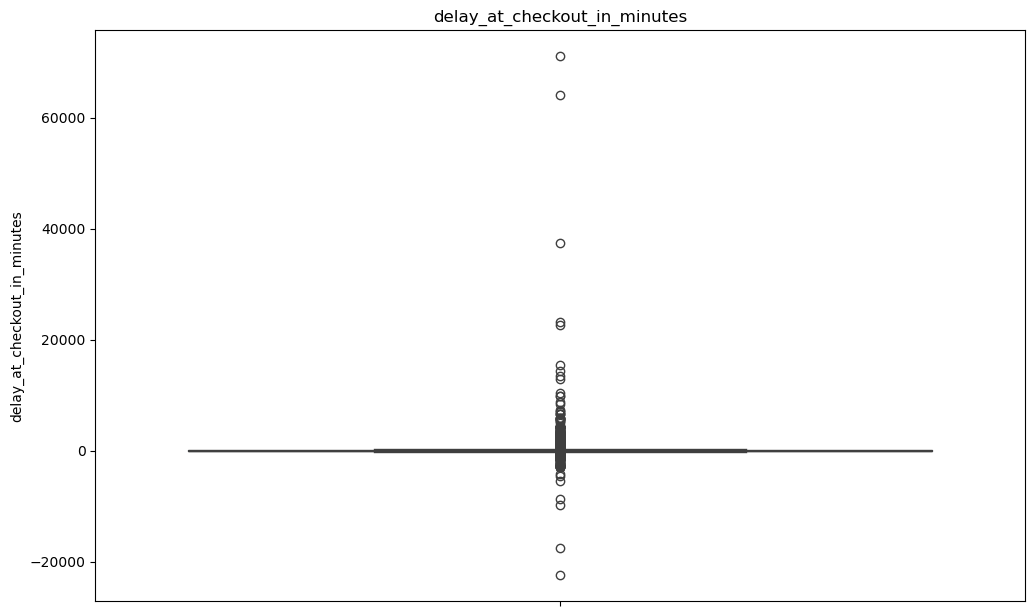

In [221]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.boxplot(df, y="delay_at_checkout_in_minutes", legend=False)                  #palette=palette_gender, hue="gender" ,  
plt.title("delay_at_checkout_in_minutes")
plt.show()

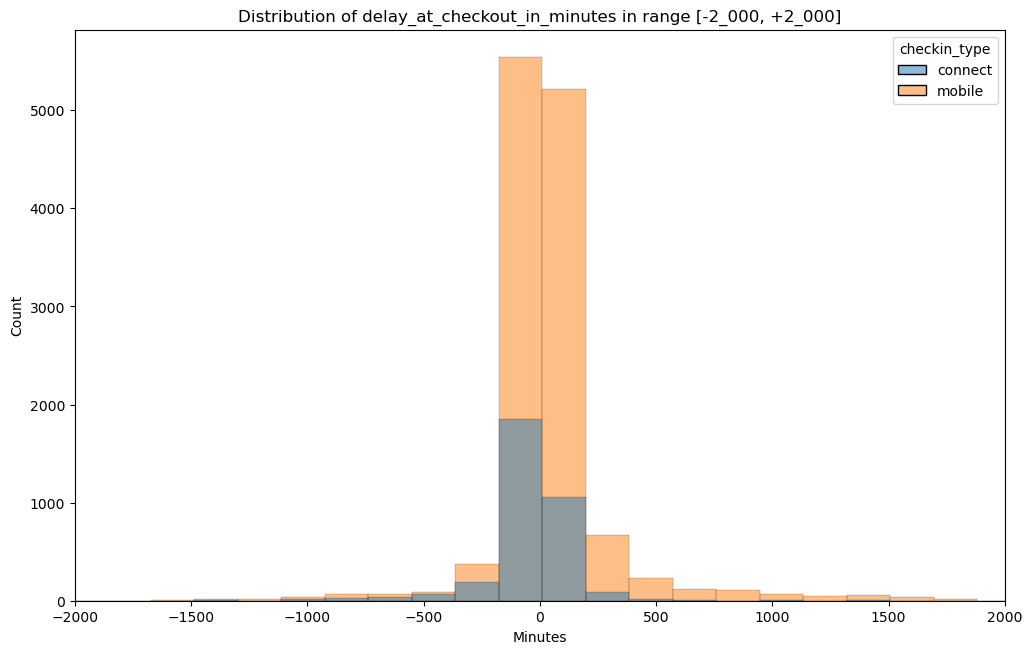

In [222]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="delay_at_checkout_in_minutes", hue="checkin_type", hue_order = ["connect", "mobile"], bins=500) #, bins=100, , kde=True

ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
ax.set_xlabel("Minutes")
ax.set_xlim(-2000, 2000)
plt.show()

# How often are drivers late for the next check-in? How does it impact the next driver?

### <span style="color:orange"><b>Comments :</b></span>

The figure below explains how it works :
1. Cars are supposed to be returned before **Checkout**  
1. If not, we call **Delay** (``delay_at_checkout_in_minutes``) the period of time between the **Checkout** and the **Return Time**
1. The owner of the car may set up a **Time $\Delta$** between 2 consecutive bookings :
    * Length of the **Time $\Delta$** ranges from 0 to 720 min. by steps of 30 min.
    * Among others things, this **Time $\Delta$** period can act as a shock absorber if the previous customer is late returning the car
        * The owner may rent his car less often, but in return he protects himself from late returns. 
        * This avoids a certain amount of friction with unhappy customers.
    * In any case, if the previous customer returns the car after **Checkout** + **Time $\Delta$** then the next booking is problematic and it can be canceled


**IMPORTANT :**

We consider that the next driver is be impacted if :
1. The transaction is in state `ended` but the return the car happens after **Checkout** + **Time $\Delta$** 
1. The current transaction is in state ``canceled`` while `previous_ended_rental_id` exists. 
    * We can assume that the transaction was cancelled precisely because the previous driver was late.
    <!-- * This happens when the current customer cancels the transaction because the previous driver is simply too late  -->

    

<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 


## How often are drivers late for the next check-in?

With the help of the previous explanation, we consider drivers were late when :
1. The transactions in state `ended` AND `delay_at_checkout_in_minutes` is greater than 0 
2. The transactions in state `canceled` AND there is a `previous_ended_rental_id` 
    * Again, in this case we can assume that the transaction was cancelled precisely because the previous driver was late.
    * However, we don't know precisely how long after the planned Checkout, the previous driver returned the car

Once grouped together we have a set of transactions where the driver was late.

In [223]:
df_tmp = df[(df['state']=="canceled") & (df['previous_ended_rental_id'].notna())]
display(df_tmp.sample(10))
len(df_tmp)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
16666,536171,392368,connect,canceled,NaN,515799,600.0
16356,546561,346755,connect,canceled,NaN,569802,270.0
16400,558219,376677,connect,canceled,NaN,563347,660.0
16482,534119,392656,mobile,canceled,NaN,554740,0.0
16583,549066,409663,mobile,canceled,NaN,544279,600.0
16491,560273,275364,connect,canceled,NaN,553244,240.0
16579,557494,365926,connect,canceled,NaN,544742,150.0
16359,569293,364670,mobile,canceled,NaN,568767,0.0
16428,543223,376311,connect,canceled,NaN,560879,600.0
16585,543807,340616,connect,canceled,NaN,543796,510.0


229

In [224]:
df_tmp2 = df[df['state']=="ended"]
display(df_tmp2.sample(10))
len(df_tmp2)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
14499,551494,404130,connect,ended,-111.0,NaN,NaN
7884,541996,283004,mobile,ended,11.0,NaN,NaN
18257,537047,408074,mobile,ended,NaN,NaN,NaN
4073,569176,410396,mobile,ended,67.0,NaN,NaN
7675,555120,382716,mobile,ended,13.0,NaN,NaN
574,547164,364890,mobile,ended,597.0,NaN,NaN
6634,555858,406563,mobile,ended,24.0,NaN,NaN
1321,567069,340900,mobile,ended,242.0,NaN,NaN
16975,544218,216510,mobile,ended,NaN,NaN,NaN
7216,545976,402308,mobile,ended,17.0,NaN,NaN


18045

Late returns         : 9633
On time returns      : 6941
Returns without info : 1700


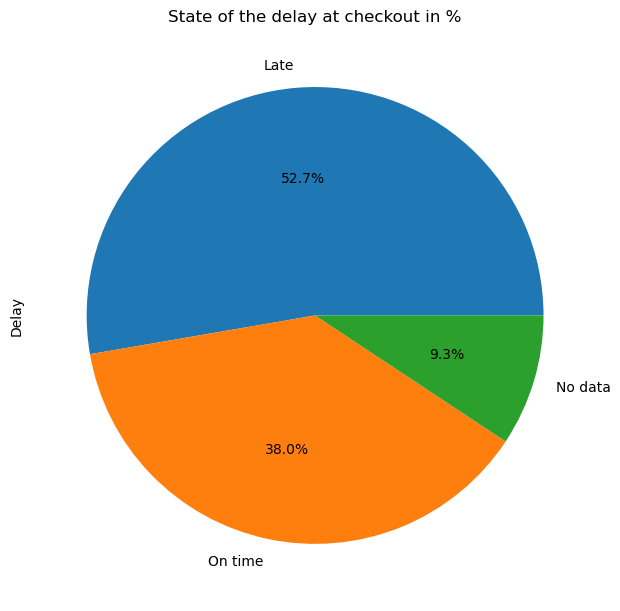

In [225]:
df_tmp = pd.concat([df_tmp, df_tmp2])
n = len(df_tmp)

nb_late_canceled = len(df_tmp[df_tmp['state']=="canceled"])
nb_late_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0) & (df_tmp['state']=="ended")])              
nb_ontime_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] <= 0)           & (df_tmp['state']=="ended")]) 
nb_nodata_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'].isna())         & (df_tmp['state']=="ended")]) 
nb_late = nb_late_canceled+nb_late_ended

print(f"Late returns         : {nb_late}")
print(f"On time returns      : {nb_ontime_ended}")
print(f"Returns without info : {nb_nodata_ended}")

data = {
    'Delay': [nb_late, nb_ontime_ended, nb_nodata_ended],
    'Ended': ["Late", "On time", "No data"]
}
df_pie = pd.DataFrame(data)

_ = df_pie["Delay"].plot.pie(
    title="State of the delay at checkout in %", 
    labels=df_pie["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))



### <span style="color:orange"><b>Comments :</b></span>

* More than 50% of the returns are late
* Less than 40% are on time
* 10% of returns have no data about the `delay_at_checkout_in_minutes`
* We should first focus on getting more delay information
    * <span style="color:orange"><b>Proposal :</b></span> A car should not be be displayed in the search results as long as the info about `delay_at_checkout_in_minutes` in not filled



## Can we have a better understanding of the delays ?

* Since on the ``Canceled`` bookings we don't have accurate data about the delays after the Checkout and since they only count for 1% ($\frac{229}{229+18045}$)
* From now, we focus on Delays of the ``Ended`` returns (the ones which are not canceled)


In [226]:
df_tmp = df[df['state']=="ended"]
display(df_tmp.sample(10))
len(df_tmp)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
1801,555451,390702,connect,ended,175.0,560568,120.0
16010,550877,397965,mobile,ended,-572.0,NaN,NaN
6112,513358,354821,mobile,ended,30.0,NaN,NaN
12664,556283,304447,mobile,ended,-45.0,NaN,NaN
996,543138,391379,connect,ended,318.0,538099,60.0
14885,562333,280805,connect,ended,-138.0,NaN,NaN
8886,558984,392151,mobile,ended,4.0,NaN,NaN
2235,561062,275364,connect,ended,139.0,NaN,NaN
13419,550616,368432,mobile,ended,-65.0,527378,0.0
16993,541681,349171,connect,ended,NaN,NaN,NaN


18045

In [227]:
labels_in_order = ['On time', '0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df_tmp['delay_at_checkout_in_minutes'], 
    bins=[-float('inf'), 0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)

# df_tmp is a view NOT a copy this is why the line below generate a warning
# df_tmp['cat_delay'] = categories
df_tmp.loc[:, 'cat_delay'] = categories
display(df_tmp.sample(10))

print(f"Returns :")
print(f"No info      {round(df_tmp['delay_at_checkout_in_minutes'].isna().sum()/len(df_tmp)*100, 2)}")
print(round(df_tmp['cat_delay'].value_counts()/len(df_tmp)*100, 2))


C:\Users\phili\AppData\Local\Temp\ipykernel_36220\3161074045.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.loc[:, 'cat_delay'] = categories


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,cat_delay
5157,521176,351030,mobile,ended,44.0,NaN,NaN,30 min-1H
2099,562947,398586,connect,ended,148.0,NaN,NaN,2H-6H
6116,527701,369167,mobile,ended,30.0,NaN,NaN,10-30 min
14015,541749,281915,mobile,ended,-86.0,NaN,NaN,On time
16471,559922,338940,mobile,ended,NaN,556330,180.0,NaN
13149,557300,409126,mobile,ended,-56.0,NaN,NaN,On time
1866,541019,410055,mobile,ended,168.0,NaN,NaN,2H-6H
169,541185,391747,mobile,ended,1477.0,NaN,NaN,> 6H
16119,561678,316678,connect,ended,-760.0,560439,180.0,On time
5473,566538,390509,connect,ended,39.0,NaN,NaN,30 min-1H


Returns :
No info      9.42
cat_delay
On time      38.46
10-30 min    10.54
1H-2H        10.16
30 min-1H     9.38
2H-6H         9.24
0-10 min      7.89
> 6H          4.90
Name: count, dtype: float64


In [228]:
df_tmp2 = pd.DataFrame(round(df_tmp['cat_delay'].value_counts()/len(df_tmp)*100, 2)).reset_index()
df_tmp2.columns = ['cat_delay', 'delay_%']

df_tmp2['cat_delay'] = pd.Categorical(df_tmp2['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp2.sort_values('cat_delay', inplace=True)
df_tmp2.set_index('cat_delay', inplace=True)
print(df_tmp2)

           delay_%
cat_delay         
On time      38.46
0-10 min      7.89
10-30 min    10.54
30 min-1H     9.38
1H-2H        10.16
2H-6H         9.24
> 6H          4.90


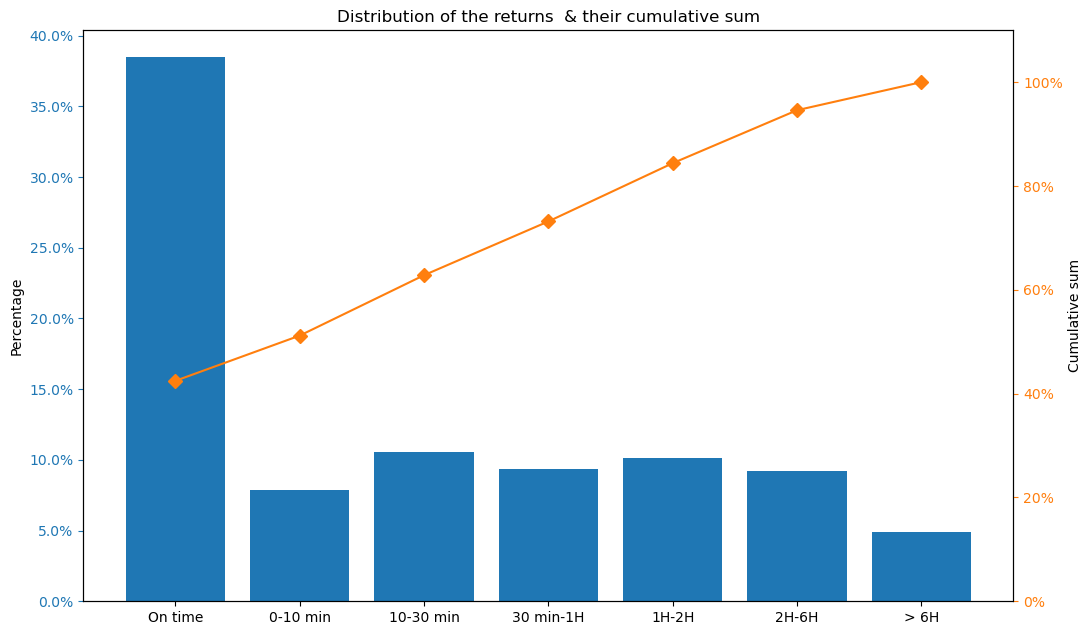

In [229]:
df_tmp2["cum_percent"] = df_tmp2["delay_%"].cumsum()/df_tmp2["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp2.index, df_tmp2["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of the returns  & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp2.index, df_tmp2["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()

Let's focus on the late retruns (delays>0) only

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,cat_delay
15673,546516,248889,connect,ended,-282.0,548781,0.0,NaN
11947,542859,368792,mobile,ended,-30.0,NaN,NaN,NaN
6365,538434,392169,mobile,ended,27.0,NaN,NaN,10-30 min
13861,542836,379244,mobile,ended,-80.0,NaN,NaN,NaN
9245,553856,308038,connect,ended,2.0,NaN,NaN,0-10 min
11847,559396,368604,connect,ended,-29.0,546242,90.0,NaN
8655,542054,381482,mobile,ended,6.0,NaN,NaN,0-10 min
5873,517515,385629,connect,ended,33.0,NaN,NaN,30 min-1H
14817,532301,363789,mobile,ended,-132.0,NaN,NaN,NaN
8191,537605,257291,mobile,ended,9.0,NaN,NaN,0-10 min


           delay_%
cat_delay         
0-10 min     15.14
10-30 min    20.23
30 min-1H    17.99
1H-2H        19.49
2H-6H        17.74
> 6H          9.41


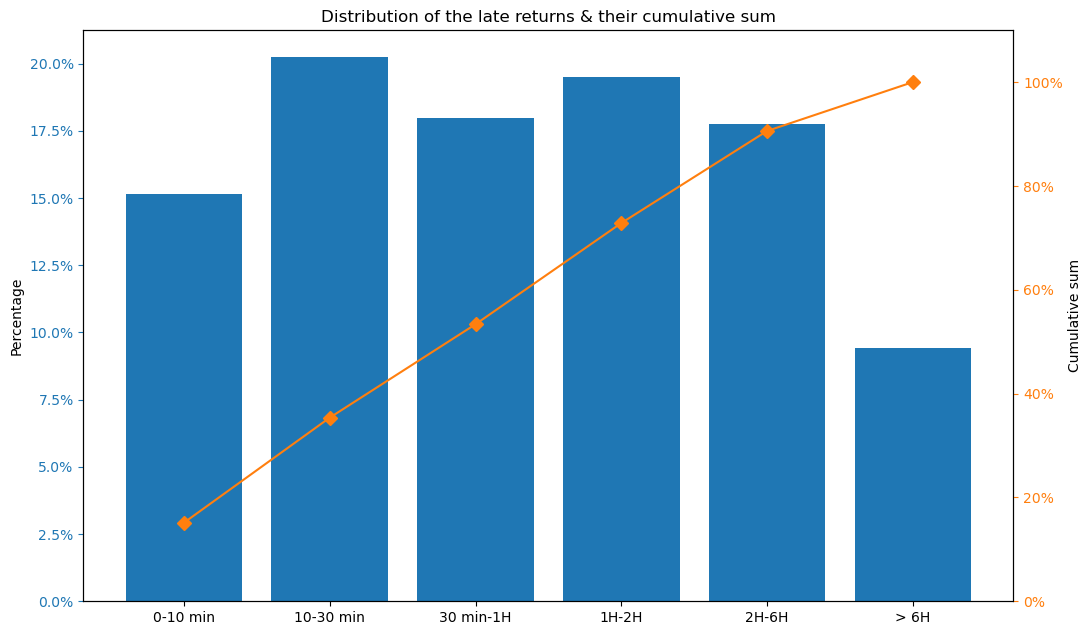

In [230]:
labels_in_order = ['0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df_tmp['delay_at_checkout_in_minutes'], 
    bins=[0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)

# df_tmp is a view, NOT a copy, this is why the line below generates a warning
# df_tmp['cat_delay'] = categories
df_tmp.loc[:, 'cat_delay'] = categories
display(df_tmp.sample(10))



df_tmp2 = pd.DataFrame(round(df_tmp['cat_delay'].value_counts()/len(df_tmp[df_tmp["delay_at_checkout_in_minutes"]>0])*100, 2)).reset_index()
df_tmp2.columns = ['cat_delay', 'delay_%']

df_tmp2['cat_delay'] = pd.Categorical(df_tmp2['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp2.sort_values('cat_delay', inplace=True)
df_tmp2.set_index('cat_delay', inplace=True)
print(df_tmp2)

df_tmp2["cum_percent"] = df_tmp2["delay_%"].cumsum()/df_tmp2["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp2.index, df_tmp2["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of the late returns & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp2.index, df_tmp2["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* More than 50% of the late retuns are below 1H
* Almost 80% of the late retruns are below 2H
<!-- * But, again, 1/4 of the returns comes with no information about the delay -->


## How does it impact the next driver?
 
<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 


In [231]:
# total number of reservations with a positive delay_at_checkout_in_minutes 
n1 = len(df[(df['delay_at_checkout_in_minutes'] > 0 )])
print(n1)

# number of bookings with a delay_at_checkout_in_minutes greater than the allowed delay time 
# If time_delta_with_previous_rental_in_minutes exiists this means there was a previous booking
n2 = len(df[(df['delay_at_checkout_in_minutes'] > df['time_delta_with_previous_rental_in_minutes']) ])             
print (n2)

print(f"Among all the late returns, {round(n2/n1*100, 2)} % of them are problematic")
print(f"Indeed the checkout happened after the allowed delay time")


9404
270
Among all the late returns, 2.87 % of them are problematic
Indeed the checkout happened after the allowed delay time


In [ ]:
# total number of reservations with a positive delay_at_checkout_in_minutes AND 
n1 = len(df[(df['delay_at_checkout_in_minutes'] > 0 ) & (df['previous_ended_rental_id'].notna())])
print(n1)

# number of bookings with a previous rental AND a delay_at_checkout_in_minutes greater than the allowed delay time 
n2 = len(df[(df['delay_at_checkout_in_minutes'] > df['time_delta_with_previous_rental_in_minutes']) ])              #  
print (n2)

print(f"Among all the late returns between 2 consecutive bookings, {round(n2/n1*100, 2)} % of them are problematic")
print(f"Indeed the checkout happened after the allowed delay time")


# How many rentals would be affected by the feature depending on the threshold and scope we choose?


<p align="center">
<img src="./assets/with_treshold.png" alt="drawing" width="800"/>
<p> 


In [ ]:
threshold = 60

# number of reservations with delay_at_checkout_in_minutes > 0
n1 = len(df[(df['delay_at_checkout_in_minutes'] > threshold )])
print(n1)


# number of bookings with a delay_at_checkout_in_minutes greater than the allowed delay time + threshold
n2 = len(df[(df['delay_at_checkout_in_minutes'] > 0)])
print(n2)



# print(len(df[(df['delay_at_checkout_in_minutes'] > threshold)]))             #  & (df['previous_ended_rental_id'].notna())
# print(f"With a treshold of {threshold} minutes, {round(len(df[(df['delay_at_checkout_in_minutes'] > threshold + df['time_delta_with_previous_rental_in_minutes'])]) / len(df[(df['delay_at_checkout_in_minutes'] > 0 )]) * 100, 2)} % remain problematic")
print(f"With a treshold of {threshold} minutes, {round(n1/n2 * 100, 2)} % remain problematic")


In [ ]:
problematic_rates = []

for threshold in thresholds:
    # Filter data for delays exceeding the threshold
    delayed_rentals = delay_data[delay_data['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the percentage of problematic delays for each threshold
    problematic_rate = (len(delayed_rentals) / len(delay_data)) * 100
    problematic_rates.append(problematic_rate)

# Create a line plot to visualize the impact of different thresholds
fig = px.line(x=thresholds, y=problematic_rates, markers=True, title='Impact of Delay Threshold on Problematic Delays')
fig.update_layout(xaxis_title='Delay Threshold (minutes)', yaxis_title='Percentage of Problematic Delays')
fig.show()

# How many problematic cases will it solve depending on the chosen threshold and scope?


# Which share of our owner’s revenue would potentially be affected by the feature?

# <span style="color:red"><b>Scrap book - Please ignore</b></span>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

df = pd.DataFrame({'country': [177.0, 7.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0]})
df.index = ['USA', 'Canada', 'Russia', 'UK', 'Belgium', 'Mexico', 'Germany', 'Denmark']
df = df.sort_values(by='country',ascending=False)
df["cum_percent"] = df["country"].cumsum()/df["country"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["country"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'couleurs': ['rouge', 'vert', 'bleu', 'rouge', 'bleu'],
    'valeurs': [10, 20, 30, 40, 50]
})

order = ['bleu', 'rouge', 'vert']

df['couleurs'] = pd.Categorical(df['couleurs'], categories=order, ordered=True)
df.sort_values('couleurs', inplace=True)
print(df)

In [ ]:
df_tmp = pd.DataFrame({'Delay': [23.29, 32.58, 3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['No info', 'On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
df_tmp = pd.DataFrame({'Delay': [3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
categories = pd.cut(df['delay_at_checkout_in_minutes'], 
                    bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
                    labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

df['cat_delay'] = categories

# df.sample(20)
print(f"Returns :")
print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(20)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(20)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# df_tmp = quick_View(df)
# print(f"\n\nQuickView :")
# display(df_tmp.sort_values(by="# null", ascending=False))   


In [ ]:
# tmp_df = df[df['delay_at_checkout_in_minutes']>0]

# fig, ax = plt.subplots(figsize=(k_Width,k_Height))
# sns.histplot(data=tmp_df, x="delay_at_checkout_in_minutes", bins=100) #, bins=100, , kde=True, , hue="checkin_type", bins=500
# ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
# ax.set_xlabel("Minutes")
# plt.show()

In [ ]:
# len((df_tmp[df_tmp['state']=="ended"]))
# len(df[(df['delay_at_checkout_in_minutes'].notna())])
# len((df[df['delay_at_checkout_in_minutes'].notna()]) & (df[df['state']=="canceled"]))
# len(df[(df['delay_at_checkout_in_minutes'].notna()) & (df[df['state']=="canceled"])       ]) 


In [ ]:
# this is WRONG
# cannot divide by len(df) since we would count ended and canceled while delay ONLY happen on ended returns 
print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes']>0])/len(df)*100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes']<=0])/len(df)*100, 2)} %")
print(f"Returns without info : {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)} %")



Late returns         : 44.13 %
On time returns      : 32.58 %
Returns without info : 23.29 %


18045
Late returns         : 52.11 %
Late returns         : 38.47 %
Returns without info : 9.42 %


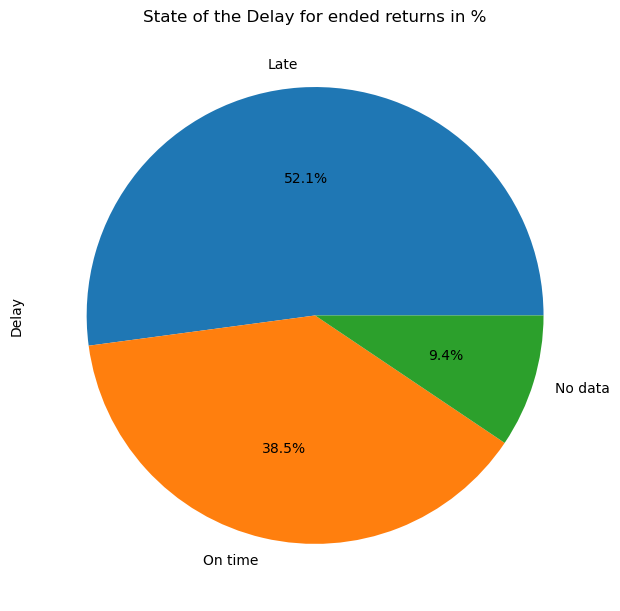

In [ ]:
# I don't see how to use a pivot table here since I want to count positives, negatives and Nan    
# ! use size() and NOT count()
# df_pivot = df.pivot_table(index='Age', columns='Gender', aggfunc='size')     
# display(df_pivot)     

n0 = len((df[df['state']=="ended"]))
# print(n0)

n1 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']>0)             ]))
# print(n1)

n2 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']<=0)            ]))
# print(n2)

n3 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes'].isna())        ]))
# print(n3)

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))

print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes'] > 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes'] <= 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"Returns without info : {round(len((df[(df['state']=='ended')     &      (df['delay_at_checkout_in_minutes'].isna())        ]))/len(df[df['state'] == 'ended'])*100, 2)} %")




,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,cat_delay
9817,551652,356434,mobile,ended,-3.0,NaN,NaN,On time
17728,515264,257398,mobile,ended,NaN,NaN,NaN,NaN
17205,538703,364890,mobile,ended,NaN,NaN,NaN,NaN
3956,559291,357958,mobile,ended,70.0,NaN,NaN,1H-2H
4162,566237,350477,mobile,ended,65.0,NaN,NaN,1H-2H
2090,558875,356260,mobile,ended,149.0,NaN,NaN,2H-6H
12889,559060,248889,connect,ended,-50.0,NaN,NaN,On time
14843,536269,315040,mobile,ended,-134.0,NaN,NaN,On time
13289,558647,407055,connect,ended,-60.0,NaN,NaN,On time
814,567029,378522,mobile,ended,402.0,NaN,NaN,> 6H


Late returns         : 52.11 %
On time returns      : 38.46 %
Returns without info : 9.42 %


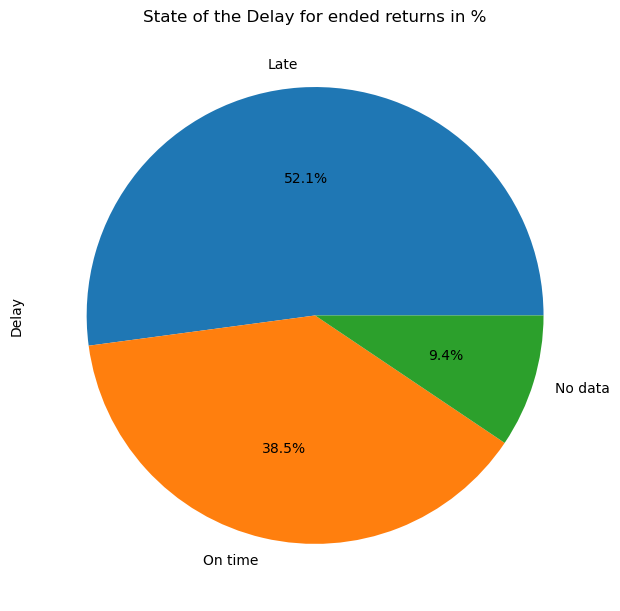

In [ ]:
df_tmp = df[df['state']=="ended"]
display(df_tmp.sample(10))

n = len(df_tmp)
p1 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'] > 0])    /n * 100
p2 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'] <= 0])   /n * 100
p3 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'].isna()]) /n * 100

print(f"Late returns         : {p1:.2f} %")
print(f"On time returns      : {p2:.2f} %")
print(f"Returns without info : {p3:.2f} %")

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))



18045
Late returns         : 52.11 %
Late returns         : 38.47 %
Returns without info : 9.42 %


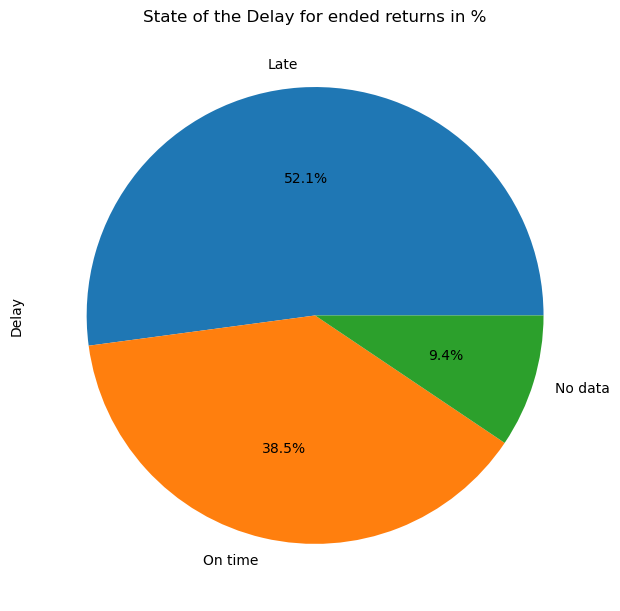

In [ ]:
# I don't see how to use a pivot table here since I want to count positives, negatives and Nan    
# ! use size() and NOT count()
# df_pivot = df.pivot_table(index='Age', columns='Gender', aggfunc='size')     
# display(df_pivot)     

n0 = len((df[df['state']=="ended"]))
# print(n0)

n1 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']>0)             ]))
# print(n1)

n2 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']<=0)            ]))
# print(n2)

n3 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes'].isna())        ]))
# print(n3)

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))

print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes'] > 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes'] <= 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"Returns without info : {round(len((df[(df['state']=='ended')     &      (df['delay_at_checkout_in_minutes'].isna())        ]))/len(df[df['state'] == 'ended'])*100, 2)} %")


